<a href="https://colab.research.google.com/github/KPMcDonough49/Capstone/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model Building 

In [ ]:
image_width = 300
image_height = 300
image_channels = 3
image_size = (image_width, image_height)
batch_size = 10

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Aug_Images",
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 2514 images belonging to 2 classes.


In [ ]:
total_train = len(train_generator.filenames)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/test", 
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False 
)

Found 302 images belonging to 2 classes.


In [ ]:
total_test = len(test_generator.filenames)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="/content/drive/MyDrive/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 147, 147, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 147, 147, 64)      0

In [ ]:
epochs = 50

history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    batch_size=batch_size,
    callbacks=callbacks_list
)

Epoch 1/50
252/252 [==============================] - 1918s 7s/step - loss: 1.0880 - accuracy: 0.6335 - val_loss: 0.5354 - val_accuracy: 0.7318

Epoch 00001: val_accuracy improved from -inf to 0.73179, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 2/50
252/252 [==============================] - 34s 133ms/step - loss: 0.5586 - accuracy: 0.7603 - val_loss: 0.8151 - val_accuracy: 0.5993

Epoch 00002: val_accuracy did not improve from 0.73179
Epoch 3/50
252/252 [==============================] - 35s 139ms/step - loss: 0.5227 - accuracy: 0.7666 - val_loss: 0.5011 - val_accuracy: 0.7815

Epoch 00003: val_accuracy improved from 0.73179 to 0.78146, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 4/50
252/252 [==============================] - 35s 136ms/step - loss: 0.4592 - accuracy: 0.7992 - val_loss: 0.4858 - val_accuracy: 0.7715

Epoch 00004: val_accuracy did not improve from 0.78146
Epoch 5/50
252/252 [==============================] - 33s 129ms/step - loss:

In [ ]:
best_model = load_model("/content/drive/MyDrive/weights.best.hdf5")

In [ ]:
best_model.save('my_model.h5')

In [ ]:
y_pred = best_model.predict(test_generator)

In [ ]:
test_preds = np.argmax(y_pred, axis=-1)

In [ ]:
conf = confusion_matrix(test_generator.classes, test_preds)
conf

array([[139,  12],
       [ 17, 134]])

In [ ]:
test_generator.class_indices

{'Infection': 0, 'No_Infection': 1}

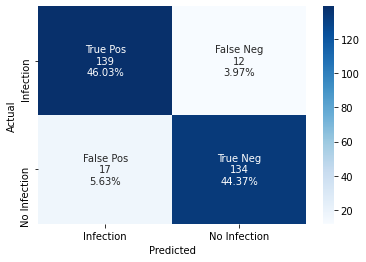

In [ ]:
group_names = ['True Pos', 'False Neg','False Pos','True Neg']

group_counts = ["{0:0.0f}".format(value) for value in
                conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf.flatten()/np.sum(conf)]
               
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf, annot=labels, fmt='', cmap='Blues', xticklabels=['Infection', 'No Infection'], yticklabels=['Infection', 'No Infection']);
plt.ylabel('Actual');
plt.xlabel('Predicted');

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

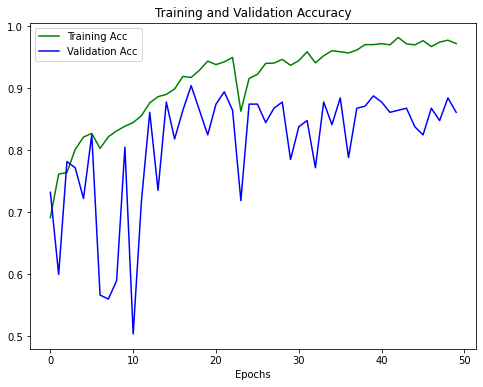

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend();


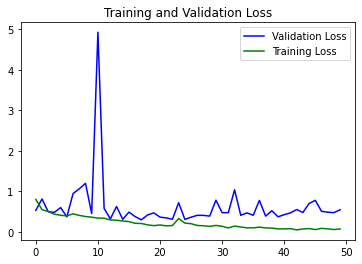

In [ ]:
plt.figure()
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()